# Intro

In this notebook, I read all the result files from each competitor method to create a summary figure.
The metrics I use are RMSE and Pearson correlation on the expression and log2FC.
The experiments I perform comparisons on are: None stimulated, All stimulated, cell-type specific stimulation

In [64]:
# general imports
import warnings
import numpy as np
from scipy.stats import spearmanr, pearsonr, ttest_ind, wilcoxon


# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# programming stuff
import time
import os
import pickle
from pathlib import Path

# import the SC_preprocessing code
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
from sc_preprocessing import sc_preprocess
from method_comparison import validation_plotting as vp


In [65]:
## parameters
aug_data_path = f"{os.getcwd()}/../data/single_cell_data/augmented_kang_data/"
res_data_path = f"{os.getcwd()}/../results/single_cell_data/buddiM2_kang/"
cibersort_genes_path = (f"{os.getcwd()}/../results/single_cell_data/cibersort_kang/" +
                        "CIBERSORTx_Job17_kang_1_cybersort_sig_inferred_phenoclasses" +
                        ".CIBERSORTx_Job17_kang_1_cybersort_sig_inferred_refsample.bm.K999.txt")

# cibersort results
cibersort_file_path = f"{os.getcwd()}/../results/single_cell_data/cibersort_kang/CIBERSORTx_Job18_Results.csv"

# bp results
bp_res_path = f"{os.getcwd()}/../results/single_cell_data/bp_kang/"

# DiffExp results
de_res_path = f"{os.getcwd()}/../data/single_cell_data/kang_rybakov/kang_DE_paper.tsv"

num_genes = 7000


In [66]:
exp_type = "mono-kang"

buddi_file = os.path.join(res_data_path, f"{exp_type}_pearson_matr.csv")
pca_file = os.path.join(f"{os.getcwd()}/../results/single_cell_data/PCA_kang/", f"{exp_type}_pearson_PCA.csv")
cvae_file = os.path.join(f"{os.getcwd()}/../results/single_cell_data/CVAE_kang/", f"{exp_type}_pearson_CVAE.csv")

buddi_df = pd.read_csv(buddi_file, sep=",")
buddi_df["expr_r2"] = buddi_df["expr_r2_stim"]

pca_df = pd.read_csv(pca_file, sep=",")
pca_df["expr_r2"] = pca_df["expr_r2_stim"]


cvae_df = pd.read_csv(cvae_file, sep=",")
cvae_df["expr_r2"] = cvae_df["expr_r2_stim"]



# format the corr
buddi_df["method"] = ["BuDDI"]*buddi_df.shape[0]
pca_df["method"] = ["PCA"]*pca_df.shape[0]
cvae_df["method"] = ["CVAE"]*cvae_df.shape[0]

plot_df = pd.concat([buddi_df, pca_df, cvae_df])




In [67]:
plot_df

,sample_id,cell_type,bulk_type,expr_r2_stim,expr_r2_ctrl,log2FC_r2,log2FC_r2_bottom,log2FC_r2_mid,log2FC_r2_top,log2FC_rmse,expr_stim_rmse,expr_ctrl_rmse,expr_r2,method
0,101,B,cell_type_specific,0.806923,0.816071,0.816508,0.637357,0.879297,0.894411,1.016262,526.433439,485.821341,0.806923,BuDDI
1,101,CD14_Mono,cell_type_specific,0.913380,0.911393,0.692093,0.448016,0.747420,0.884864,2.060684,283.471209,278.576336,0.913380,BuDDI
2,101,CD16_Mono,cell_type_specific,0.858463,0.867412,0.807338,0.617129,0.877588,0.899707,1.042521,410.508649,363.774421,0.858463,BuDDI
3,101,CD4_Mem_T,cell_type_specific,0.823250,0.833297,0.822775,0.620683,0.887977,0.909582,1.017608,494.539079,450.780825,0.823250,BuDDI
4,101,CD4_Naive_T,cell_type_specific,0.831771,0.844593,0.809833,0.604583,0.891303,0.882206,1.025305,669.133890,634.273024,0.831771,BuDDI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,1488,CD8_T,cell_type_specific,0.787518,0.808216,0.720211,0.502650,0.805153,0.877350,1.609148,506.790005,518.190291,0.787518,CVAE
176,1488,DC,cell_type_specific,0.772689,0.816905,0.696834,0.533512,0.721894,0.866442,1.648016,553.511929,523.024530,0.772689,CVAE
177,1488,Mk,cell_type_specific,0.793164,0.810671,0.716855,0.512564,0.813450,0.861351,1.638062,524.086705,537.491059,0.793164,CVAE
178,1488,NK,cell_type_specific,0.788462,0.803219,0.722138,0.509412,0.830299,0.858279,1.611533,550.466857,540.122473,0.788462,CVAE


In [68]:
s = plot_df.groupby(["method"]).agg({'expr_r2': ['median', 'std'],
                                 'log2FC_r2': ['median', 'std'],
                                 'log2FC_rmse': ['median', 'std']})

s = s.style.format('{:.3f}')
s


In [69]:
a2 = plot_df.groupby(["method"])["expr_r2", "log2FC_r2", "log2FC_rmse"].std()


<ipython-input-69-2eec0688e9f9>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  a2 = plot_df.groupby(["method"])["expr_r2", "log2FC_r2", "log2FC_rmse"].std()


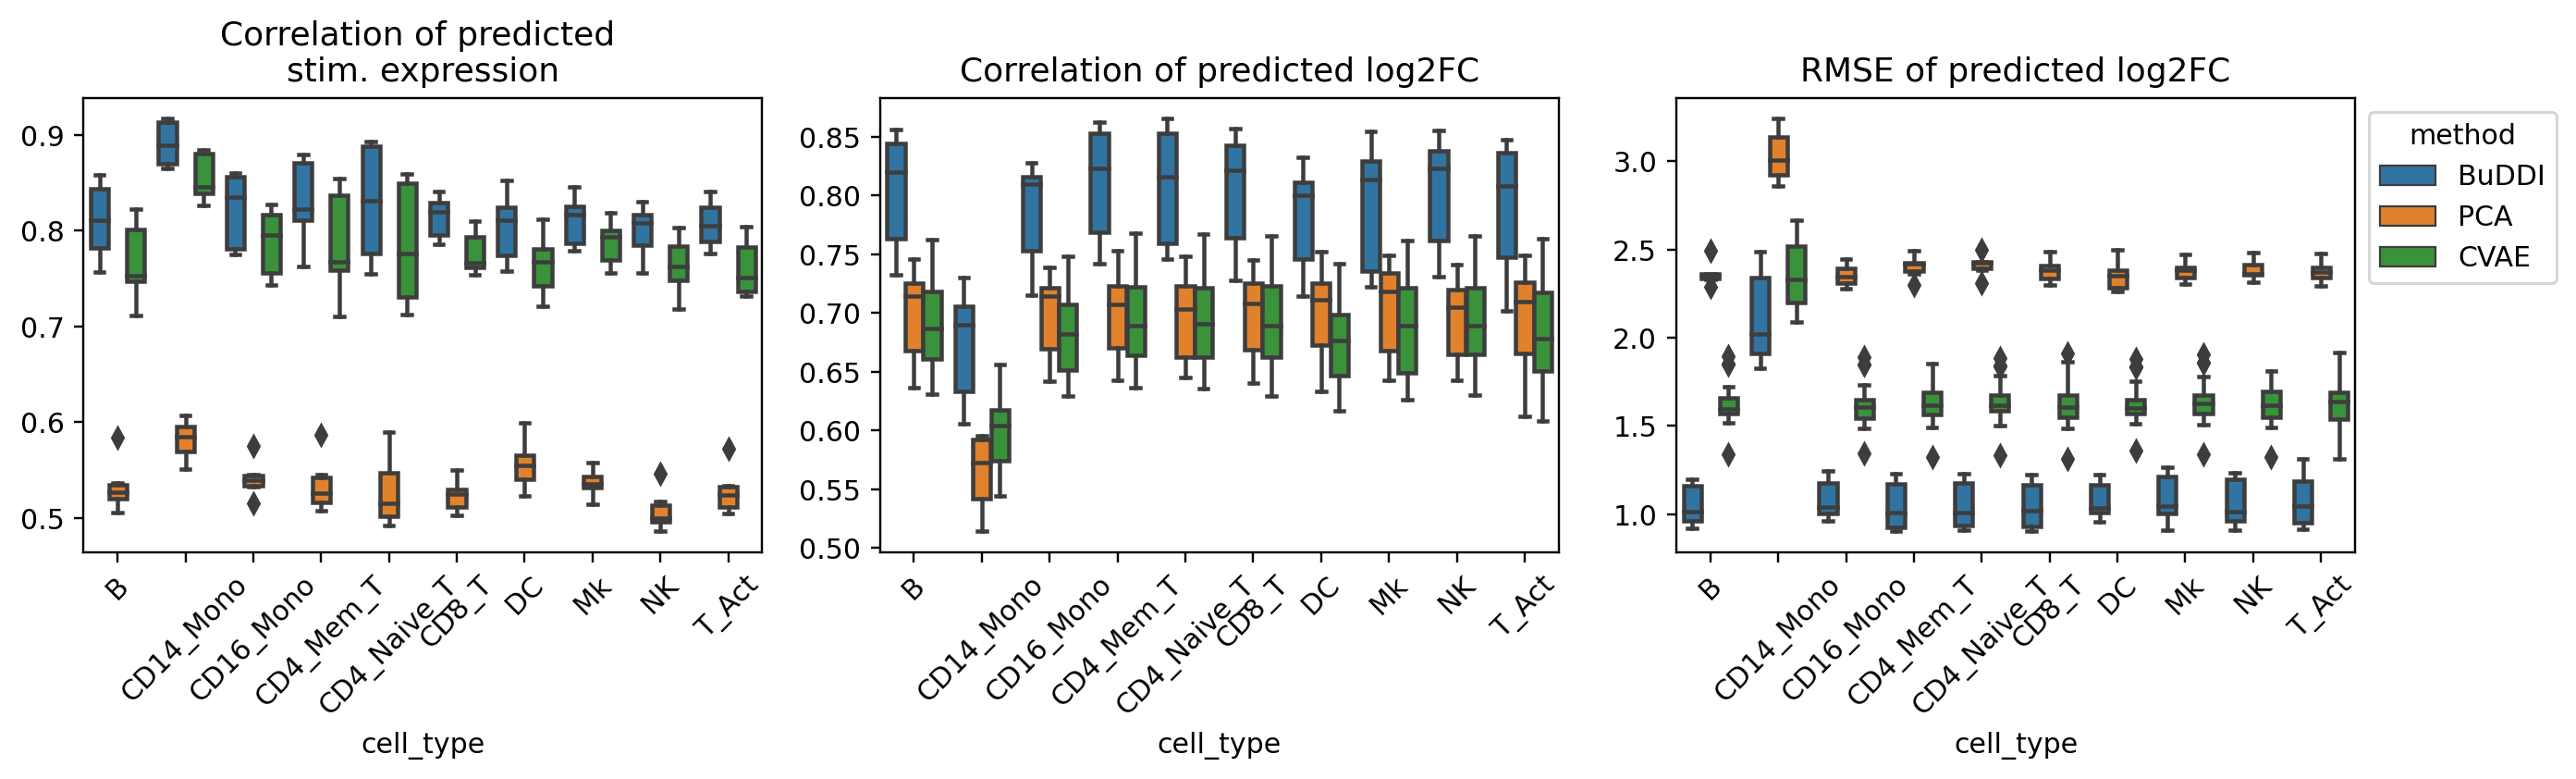

In [76]:

# plot
fig, axs = plt.subplots(1, 3, figsize=(13,4), dpi=216)

sns.boxplot(data=plot_df[plot_df["bulk_type"] == "cell_type_specific"], 
            x="cell_type", y="expr_r2",
            hue="method", ax= axs[0])
axs[0].set_title("Correlation of predicted \nstim. expression")
axs[0].set(ylabel="pearson corr.")
axs[0].tick_params(axis='x', rotation=45)


sns.boxplot(data=plot_df[plot_df["bulk_type"] == "cell_type_specific"], 
            x="cell_type", y="log2FC_r2",
            hue="method", ax= axs[1])
axs[1].set_title("Correlation of predicted log2FC")
axs[1].set(ylabel="pearson corr.")
axs[1].tick_params(axis='x', rotation=45)


sns.boxplot(data=plot_df[plot_df["bulk_type"] == "cell_type_specific"], 
            x="cell_type", y="log2FC_rmse",
            hue="method", ax= axs[2])
axs[2].set_title("RMSE of predicted log2FC")
axs[2].set(ylabel="pearson corr.")
axs[2].tick_params(axis='x', rotation=45)


axs[0].get_legend().remove()
axs[1].get_legend().remove()
sns.move_legend(axs[2], "upper left", bbox_to_anchor=(1, 1))


y_axis = axs[0].axes.get_yaxis()
y_label = y_axis.get_label()
y_label.set_visible(False)

y_axis = axs[1].axes.get_yaxis()
y_label = y_axis.get_label()
y_label.set_visible(False)

y_axis = axs[2].axes.get_yaxis()
y_label = y_axis.get_label()
y_label.set_visible(False)

fig.show()
fig.tight_layout()



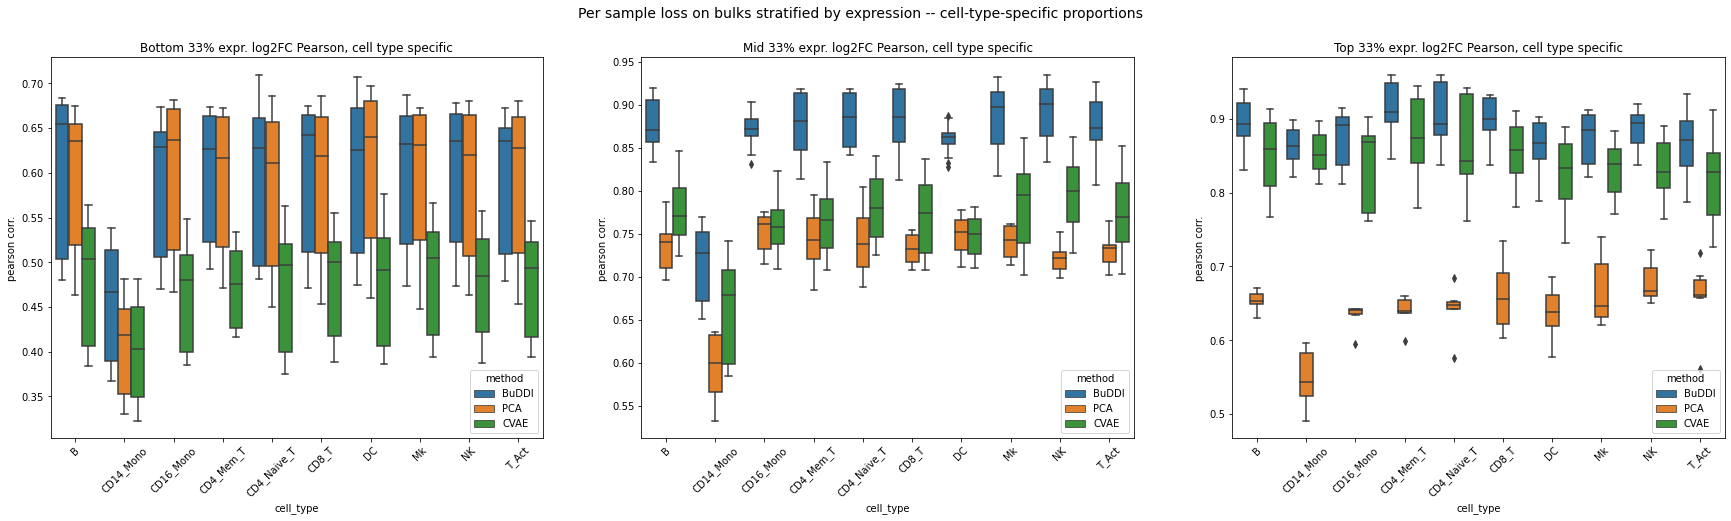

In [71]:

fig, axs = plt.subplots(1, 3, figsize=(30,7))

sns.boxplot(data=plot_df[plot_df["bulk_type"] == "cell_type_specific"], 
            x="cell_type", y="log2FC_r2_bottom",
            hue="method", ax= axs[0])
axs[0].set_title("Bottom 33% expr. log2FC Pearson, cell type specific")
axs[0].set(ylabel="pearson corr.")
axs[0].tick_params(axis='x', rotation=45)


sns.boxplot(data=plot_df[plot_df["bulk_type"] == "cell_type_specific"], 
            x="cell_type", y="log2FC_r2_mid",
            hue="method", ax= axs[1])
axs[1].set_title("Mid 33% expr. log2FC Pearson, cell type specific")
axs[1].set(ylabel="pearson corr.")
axs[1].tick_params(axis='x', rotation=45)



sns.boxplot(data=plot_df[plot_df["bulk_type"] == "cell_type_specific"], 
            x="cell_type", y="log2FC_r2_top",
            hue="method", ax= axs[2])
axs[2].set_title("Top 33% expr. log2FC Pearson, cell type specific")
axs[2].set(ylabel="pearson corr.")
axs[2].tick_params(axis='x', rotation=45)



fig.suptitle("Per sample loss on bulks stratified by expression -- cell-type-specific proportions", fontsize=14)

fig.show()


